# Installing pysolve3 package and loading libraries




In [1]:
%config InlineBackend.figure_format = 'retina'

from pysolve3.model import Model
from pysolve3.utils import SolveSFC, ShockModel, SummaryShock

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sympy as sp
import networkx as nx
from datetime import datetime as dt

/home/gpetrini/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def create():
    model = Model()

    # Accounting
    model.set_var_default(0)
    model.var('Y', desc='GDP', default = 31.372549019607845)
    model.var('C', desc='Consumption', default = 14.640522875816991)
    model.var('Id', desc='Investment', default = 6.274509803921569) # I is reserved to numpy
    model.var('Omega', desc='Wage share')
    model.var('Pi', desc='Profit share', default = 0.411765)
    
    # Identities
    model.var('K', desc='Capital Stock', default = 100)
    #model.var('K', desc='Capital Stock', default = 98.03922)
    model.var('gk', desc='Capital Stock growth rate')
    model.var('Yfc', desc='Full Capacity out-put')
    model.var('u', desc='Capacity utilization ration')
    
    # Households
    model.var('Yh', desc='Households’ income')
    model.var('Ydh', desc='Households’ disposable income')
    model.var('W', desc='Wages')
    model.var('FD', desc='Profits', default = 6.829805584130843)
    model.var('Mh', desc='Bank deposits')
    model.var('B', desc='Government Bills', default = 73.65483130189038)
    model.var('Sh', desc='Savings of Household', default = 3.1655184596361137)
    model.var('Vh', desc='Household net wealth', default = 161.44144144144184)
    model.var('pe', desc='Equities price', default = 0.9880216216216237)
    model.var('Lambda', desc='proportion of household wealth allocated in equities')
    model.var('Eq', desc='Equities', default = 9.80392156862745) # E is reserved for sympy

    # Firms
    model.var('Lf', desc='Firms Loans', default = 78.29005476064303)
    model.var('FU', desc='Retained profits', default = 4.553203722753896)
    model.var('Ft', desc='Total profits')
    model.var('Fg', desc='Gross Profits')
    model.var('h', desc='Propensity to invest', default = 0.2)
    
    
    # Government
    model.var('G', desc='Government Expenditure', default = 10.457516339869283)
    model.var('T', desc='Taxes')
    
    # Profits
    model.var('rn', desc='Net profit rate')
    model.var('rg', desc='Gross profit rate')
    
    # Accouting
    model.param('v', desc='Capital-Output ratio', default = 2.5)
    model.param('mu', desc='Mark-up', default = 0.7)
    
    #-----------------------------
    # Identities
    model.param('delta', desc='Depreciation', default = 0.044)
    
    # Households
    model.param('Lambda0', desc='Expectation of return', default = 0.08)
    model.param('alpha1', desc='Consumption Sensitivity of wages', default = 0.8)
    model.param('alpha2', desc='Consumption Sensitivity of wealth', default = 0.03375)
    model.param('rm', desc= 'Deposits interest rate', default = 0.02)
    model.param('rb', desc= 'Bills interest rate', default = 0.02)
    #model.param('rm', desc= 'Deposits interest rate', default = 0)
    #model.param('rb', desc= 'Bills interest rate', default = 0)
    model.param('tau', desc='Direct taxes', default = 0.37)
    
    # Firms
    model.param('sf', desc='Distribution of profits', default = 0.4)
    model.param('a', desc='Fixed parameter', default = 0.1)
    model.param('gamma', desc='adjstment parameter', default = 0.014)
    model.param('un', desc='Natural capacity utilization rate', default = 0.8)
    
    
    # Government
    model.param('sigma', desc='Government expenditure rate', default = 0.34)
    
    
    #-----------------------------
    model.add('B = B(-1) + G - T + rb*B(-1)') # Eq (1) # Checked
    model.add('G = sigma*Y(-1)') # Eq (2) # Checked
    #model.add('G = sigma*Y') # Eq (2)
    model.add('T= tau*Yh') # Eq (3) # Checked
    model.add('Yh = W + FD + rm*(B(-1) + Mh(-1))') # Eq (4) # Checked
    model.add('W = (1-Pi)*Y') # Eq (5) # Checked
    model.add('Ydh = (1-tau)*Yh') # Eq (6) # Checked
    model.add('C = alpha1*(1-tau)*W + alpha2*Vh(-1)') # Eq (7) # Checked
    model.add('Sh = Ydh - C') # Eq (8) # Checked
    model.add('Lambda = Lambda0 - rb') # Eq (9) # Checked
    model.add('pe = (Lambda*Vh)/Eq') # Dynamic # Eq (10) # Checked
    model.add('Vh = Vh(-1) + Sh + d(pe)*Eq(-1)') # Eq (11) # Checked
    model.add('Mh = Mh(-1) + Sh - pe*d(Eq) - d(B)') # Eq (12) # Checked
    model.add('Pi = mu/(1+mu)') # Eq (13) # Checked
    model.add('Omega = 1 - Pi') # Aux (1) # Checked
    model.add('Id = h*Y') # Eq (14) # Checked
    model.add('h = h(-1) + if_true(u - un > 0.001)*h(-1)*gamma*(u-un) + if_true(un - u > 0.001)*h(-1)*gamma*(u-un)') # Eq (15)
    model.add('K = K(-1) + Id - delta*K(-1)') # Eq (16) # Corrected (delta*K(-1))
    model.add('Yfc = K(-1)/v') # Eq (17) # Checked
    model.add('u = Y/Yfc') # Eq (18) # Checked
    model.add('gk = (h*u)/v - delta') # Eq (19) # Checked
    model.add('Lf = Lf(-1) + Id - FU - pe*d(Eq)') # Eq (20) # Checked
    model.add('Eq = a*K(-1)') # Eq (21) # Checked
    #model.add('Eq = a*K') # Eq (21)
    model.add('FU = sf*(Pi*Y - rm*Lf(-1))') # Eq (22) # Checked
    model.add('FD= (1-sf)*(Pi*Y - rm*Lf(-1))') # Eq (23) # Checked
    model.add('Ft = (Pi*Y - rm*Lf(-1))') # Eq (24) # Checked
    model.add('Fg = Pi*Y') # Eq (25)
    model.add('rn = Pi*u/v - rb*(Lf(-1))/K(-2)') # Eq (26)
    model.add('rg = Pi*u/v') # Eq (26)

    model.add('Y = C + Id + G') # Eq (28)
    #----------------
    model.var('Z', desc='Autonomous')
    
    model.add('Z = alpha2*Vh(-1)')
    
    model.var('gB', desc='Government bounds growth rate')
    model.add('gB = d(B)/B(-1)')
    
    
    model.var('gVh', desc='Vh growth rate')
    model.add('gVh = d(Vh)/Vh(-1)')
    
    return model

# Solving

In [3]:
%timeit
base = create()
df = SolveSFC(model = base, time = 2500)
df.head()

,Y,C,Id,Omega,Pi,K,gk,Yfc,u,Yh,...,_B__1,_Y__1,_Mh__1,_Vh__1,_pe__1,_Eq__1,_h__1,_K__1,_Lf__1,_K__2
0,31.372549,14.640523,6.274510,0.000000,0.411765,100.000000,0.000000,0.000000,0.000000,0.000000,...,73.654831,31.372549,0.000000,161.441441,0.988022,9.803922,0.200000,100.000000,78.290055,100.000000
1,32.004701,14.937097,6.400938,0.588235,0.411765,102.000938,0.020009,40.000000,0.800117,27.266920,...,73.654831,31.372549,0.000000,161.441441,0.988022,9.803922,0.200000,100.000000,78.290055,100.000000
2,32.577350,15.180424,6.515327,0.588235,0.411765,104.028223,0.019875,40.800375,0.798457,27.767471,...,75.705886,32.004701,-0.002487,163.620767,0.981724,10.000000,0.200000,102.000938,79.853462,100.000000
3,33.114257,15.415641,6.622317,0.588235,0.411765,106.073298,0.019659,41.611289,0.795800,28.239186,...,77.827673,32.577350,-0.006427,165.873797,0.975719,10.200094,0.199996,104.028223,81.446705,102.000938
4,33.630730,15.646974,6.724909,0.588235,0.411765,108.130983,0.019399,42.429319,0.792629,28.694684,...,80.012060,33.114257,-0.012429,168.191227,0.970071,10.402822,0.199984,106.073298,83.069826,104.028223


# Sobol

In [4]:
def sobol(
    parameters,
    filename,
    bound = np.linspace(0,1,101),
    time = 10,
    skip = 10,
):
    t2 = dt.now()
    bound = bound
    df = pd.DataFrame()
    empty_list = [i for i in range(len(bound))]  
    
    for param in parameters:
        for i in range(len(bound)):
            base = create()
            base.set_values({param:bound[i]})
            try:
                empty_list[i] = np.log(SolveSFC(base,time=time+skip)["u"][skip:].std())
            except Exception as e:
                empty_list[i] = np.nan
                pass
        df[param] = empty_list ################### Replace here
############################### End #####################################################
    df.index = bound
    
    sns.set_context('talk')
    fig, ax = plt.subplots()

    df.plot(
        ax = ax,
        lw = 2.5
    )
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\log(std(i))$")
    ax.set_xlabel("Parameters' values")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle("Sensibility analysis", fontsize = 14, weight="bold")
    ax.set_title("Simulated for {} periods, removing the {} first".format(time+skip,skip), fontsize = 12, y = .98)

    ylim = ax.get_ylim()
    fig.savefig(filename, dpi = 300)
    plt.show()
    print("Total running time: ", dt.now()-t2)
    return df


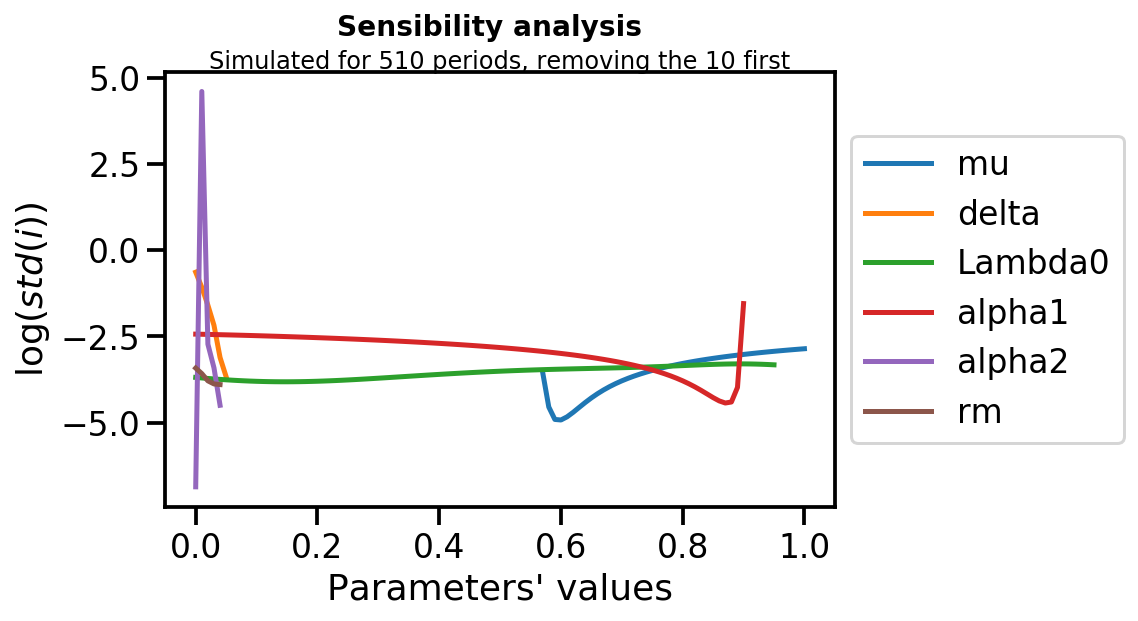

Total running time:  0:07:19.983552
CPU times: user 7min 16s, sys: 1.34 s, total: 7min 17s
Wall time: 7min 19s


,mu,delta,Lambda0,alpha1,alpha2,rm
0.00,NaN,-0.638349,-3.690922,-2.435380,-6.865553,-3.421032
0.01,NaN,-1.076632,-3.706577,-2.439245,4.604492,-3.580585
0.02,NaN,-1.595818,-3.721484,-2.443231,-2.725954,-3.790262
0.03,NaN,-2.178921,-3.735461,-2.447355,-3.412853,-3.880034
0.04,NaN,-3.114014,-3.748501,-2.451633,-4.499976,-3.898050
...,...,...,...,...,...,...
0.96,-2.917633,NaN,NaN,NaN,NaN,NaN
0.97,-2.902156,NaN,NaN,NaN,NaN,NaN
0.98,-2.887307,NaN,NaN,NaN,NaN,NaN
0.99,-2.872955,NaN,NaN,NaN,NaN,NaN


In [5]:
parameters = [i for i in base.desc_parameters.keys() if i is not 'v'][0:6]
%time sobol(time=500, parameters = parameters, filename="Sobol_01")

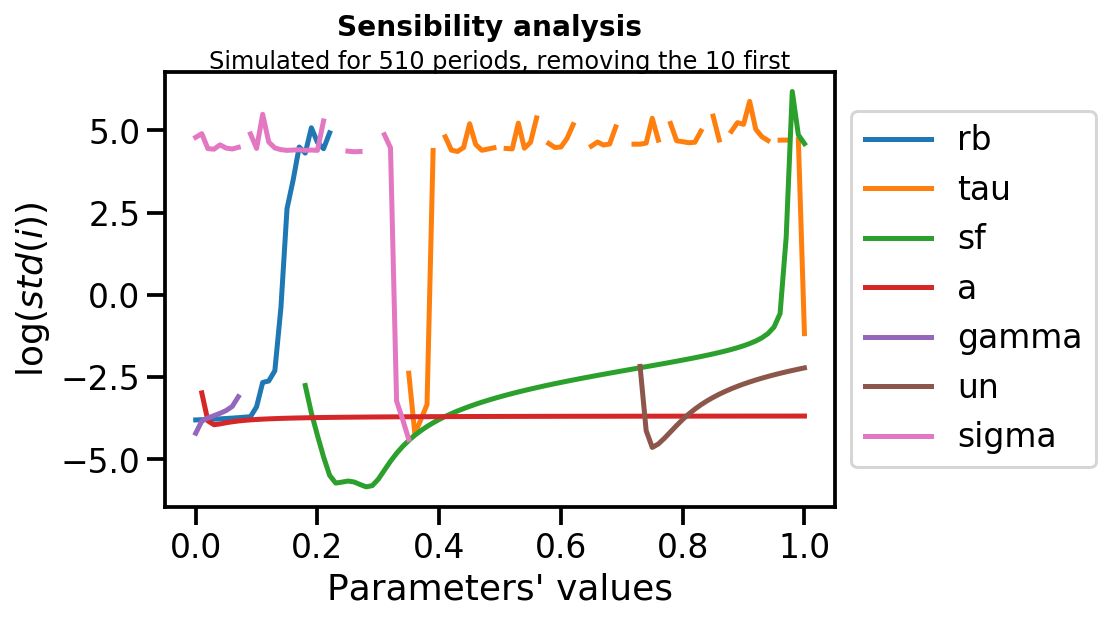

Total running time:  0:09:19.040352
CPU times: user 9min 10s, sys: 3.47 s, total: 9min 14s
Wall time: 9min 19s


,rb,tau,sf,a,gamma,un,sigma
0.00,-3.804134,NaN,NaN,NaN,-4.207836,NaN,4.787760
0.01,-3.797856,NaN,NaN,-2.982446,-3.840144,NaN,4.898647
0.02,-3.790262,NaN,NaN,-3.832366,-3.744227,NaN,4.443690
0.03,-3.781463,NaN,NaN,-3.949528,-3.674737,NaN,4.427761
0.04,-3.771561,NaN,NaN,-3.925726,-3.602853,NaN,4.559255
...,...,...,...,...,...,...,...
0.96,NaN,4.701876,-0.569851,-3.686900,NaN,-2.387209,NaN
0.97,NaN,4.703895,1.747458,-3.686773,NaN,-2.342950,NaN
0.98,NaN,NaN,6.181605,-3.686649,NaN,-2.300857,NaN
0.99,NaN,4.719076,4.861433,-3.686527,NaN,-2.260700,NaN


In [6]:
parameters = [i for i in base.desc_parameters.keys() if i is not 'v'][6:]
%time sobol(time=500, parameters = parameters, filename="Sobol_02")